# Predicting Wind Power Production 

Import libraries

In [1]:
from influxdb import InfluxDBClient # install via "pip install influxdb"
import pandas as pd 
import seaborn as sb
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import joblib
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


# Data discovery (incl simple linear regression models)

In [2]:
# Retrieve the data
client = InfluxDBClient(host='influxus.itu.dk', port=8086, username='lsda', password='icanonlyread')
client.switch_database('orkney')

def get_df(results):
    values = results.raw["series"][0]["values"]
    columns = results.raw["series"][0]["columns"]
    df = pd.DataFrame(values, columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index) # Convert to datetime-index
    return df

# Get the last 90 days of power generation data
generation = client.query(
    "SELECT * FROM Generation where time > now()-90d"
    ) # Query written in InfluxQL

# Get the last 90 days of weather forecasts with the shortest lead time
wind  = client.query(
    "SELECT * FROM MetForecasts where time > now()-90d and time <= now() and Lead_hours = '1'"
    ) # Query written in InfluxQL


gen_df = get_df(generation)
wind_df = get_df(wind)

In [3]:
wind_df1 = pd.DataFrame(wind_df[['Speed']]) # load wind forecast data
gen_df1 = pd.DataFrame(gen_df['Total']) # load power generation data

Wind and power data should be in the same dataframe such that we can later predict power generation from wind speed and direction. 
We concatenate the two dataframes and discover that gen_df has data points for every minute while wind_df has for every 3 hours. This results in a lot of NA values if we join on this basis. To fix this, I choose to resample the gen_df in a 3-hour interval using the mean. 

In [35]:
print(f"Before resampling: {gen_df1.shape}")
gen_df1 = gen_df1.resample('3h').mean()
print(f"After resampling: {gen_df1.shape}")
gen_df1.head()

Before resampling: (721, 1)
After resampling: (721, 1)


,Total
time,
2022-09-21 06:00:00+00:00,14.193816
2022-09-21 09:00:00+00:00,7.213698
2022-09-21 12:00:00+00:00,13.378758
2022-09-21 15:00:00+00:00,19.611612
2022-09-21 18:00:00+00:00,21.287554


In [36]:
# concatenate the data into one dataframe
main_df = pd.concat([wind_df1, gen_df1], axis=1)
# we have some null values after the join
print(f"Null values:\n {main_df.isnull().sum()}")

Null values:
 Speed    24
Total     1
dtype: int64


In [37]:
gen_df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 721 entries, 2022-09-21 06:00:00+00:00 to 2022-12-20 06:00:00+00:00
Freq: 3H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Total   720 non-null    float64
dtypes: float64(1)
memory usage: 11.3 KB


In [38]:
main_df.head()

,Speed,Total
time,,
2022-09-21 06:00:00+00:00,NaN,14.193816
2022-09-21 09:00:00+00:00,8.94080,7.213698
2022-09-21 12:00:00+00:00,8.94080,13.378758
2022-09-21 15:00:00+00:00,8.04672,19.611612
2022-09-21 18:00:00+00:00,9.83488,21.287554


From above we see that we the join resulted in some null values. The model we are creating later can't run with null values, so we need to fidn a way to replace those NA values. I choose to use the SimpleImputer to fill the NA values with the mean of each column.

In [39]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df = pd.DataFrame(imp_mean.fit_transform(main_df),columns=[['Speed','Total']])
df.isnull().sum()

Speed    0
Total    0
dtype: int64

Before we start training our model, we have to prepare some training and testing data:

In [40]:
X = df['Speed'] # independent variable
y = df['Total'] # dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train a Linear Regression model and make some predictions

In [41]:
# Create a linear regression model
plt.rcParams['figure.facecolor'] = 'white'

X_train = np.array(X_train).reshape(-1,1)
X_test = np.array(X_test).reshape(-1,1)
y_train = np.array(y_train).reshape(-1,1)

reg = LinearRegression().fit(X_train, y_train)

# make predictions on test data
y_pred = reg.predict(X_test)
#reg.score(X, y)

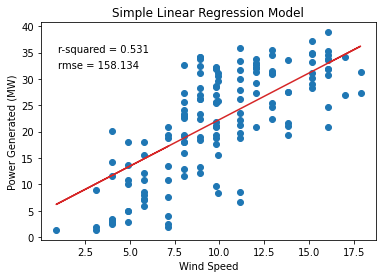

In [42]:
plt.scatter(X_test,y_test, color='tab:blue')
plt.plot(X_test,y_pred, color='tab:red')
plt.title('Simple Linear Regression Model')
plt.xlabel('Wind Speed')
plt.ylabel('Power Generated (MW)')
plt.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred)), (1, 35))
plt.annotate("rmse = {:.3f}".format(mse(X_test, y_pred), squared=False), (1, 32))
plt.savefig('SimpleLinearRegression.png')
plt.show()

In [203]:
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)
regr2 = LinearRegression().fit(X_poly,y_train)
print(f"Price = {regr2.intercept_} + {regr2.coef_} * x")
y_pred = regr2.predict(poly_reg.fit_transform(X_test))
print(f"r-squared: {round(r2_score(y_test, y_pred),2)}")
print(f"rmse: {round(mse(X_test, y_pred,squared=False),2)}")

Price = [7.47937506] + [[ 0.         -4.23727361  1.08199904 -0.0505568 ]] * x
r-squared: 0.63
rmse: 8.21


Next, we try a multiple linear regression model where we use multiple independent variables to predict the power generation

In [54]:
# only need 'Direction' and 'Speed' from the weather forecast
wind_df2 = pd.DataFrame(wind_df[['Direction','Speed']])
# let's add hour to our dataframe using the time index we have
wind_df2['Hour'] = wind_df2.index.hour
wind_df2.head()

,Direction,Speed,Hour
time,,,
2022-09-21 09:00:00+00:00,S,8.94080,9
2022-09-21 12:00:00+00:00,S,8.94080,12
2022-09-21 15:00:00+00:00,S,8.04672,15
2022-09-21 18:00:00+00:00,S,9.83488,18
2022-09-21 21:00:00+00:00,S,8.94080,21


In [55]:
# only need 'Total' column
gen_df2 = pd.DataFrame(gen_df['Total'])
# downsample by grouping from minute level to 3-hour level
gen_df2 = gen_df2.resample('3h').mean() 
gen_df2.head()

,Total
time,
2022-09-21 06:00:00+00:00,14.193816
2022-09-21 09:00:00+00:00,7.213698
2022-09-21 12:00:00+00:00,13.378758
2022-09-21 15:00:00+00:00,19.611612
2022-09-21 18:00:00+00:00,21.287554


In [56]:
# first, we join the two dataframes 
df = pd.concat([wind_df2,gen_df2], axis=1)
df.isnull().sum()

Direction    24
Speed        24
Hour         24
Total         1
dtype: int64

In [57]:
# we get some NA values after our join, which is because the timestamps of the two dataframes are not exactly the same. 
# I choose to drop the NA values since it is only concerning 46 rows out of a toal 721 (6%).
df = df.dropna()
df.isnull().sum()

Direction    0
Speed        0
Hour         0
Total        0
dtype: int64

In [47]:
with open('mytable.tex','w') as tf:
    tf.write(df.to_latex(caption="Concatenated dataframe"))
#print(df.to_latex())  
#df.head()

/var/folders/y4/plwk2b151kx5m3wc40hz9l140000gn/T/ipykernel_94568/2389746300.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(df.to_latex(caption="Concatenated dataframe"))


In [58]:
# split our data into training and testing data
X = df.drop(columns='Total')
y = df['Total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train['Hour']



time
2022-11-22 09:00:00+00:00     9.0
2022-11-27 21:00:00+00:00    21.0
2022-12-16 21:00:00+00:00    21.0
2022-11-22 03:00:00+00:00     3.0
2022-11-15 15:00:00+00:00    15.0
                             ... 
2022-11-07 06:00:00+00:00     6.0
2022-10-28 12:00:00+00:00    12.0
2022-10-10 09:00:00+00:00     9.0
2022-12-20 06:00:00+00:00     6.0
2022-11-14 21:00:00+00:00    21.0
Name: Hour, Length: 557, dtype: float64

In [59]:
# Column Transformer used to preprocess data before model training
ct = ColumnTransformer(transformers =[
    ('MinMaxScaling', MinMaxScaler(), ['Speed']),
    ("OneHotEncoder", OneHotEncoder(handle_unknown='ignore', sparse=False), ['Direction', 'Hour']),
], remainder ='passthrough')

# result of the column transformation
pd.DataFrame(ct.fit_transform(X_train), columns=ct.get_feature_names_out(), index=X_train.index)

,MinMaxScaling__Speed,OneHotEncoder__Direction_E,OneHotEncoder__Direction_ENE,OneHotEncoder__Direction_ESE,OneHotEncoder__Direction_N,OneHotEncoder__Direction_NE,OneHotEncoder__Direction_NNE,OneHotEncoder__Direction_NNW,OneHotEncoder__Direction_NW,OneHotEncoder__Direction_S,...,OneHotEncoder__Direction_WNW,OneHotEncoder__Direction_WSW,OneHotEncoder__Hour_0.0,OneHotEncoder__Hour_3.0,OneHotEncoder__Hour_6.0,OneHotEncoder__Hour_9.0,OneHotEncoder__Hour_12.0,OneHotEncoder__Hour_15.0,OneHotEncoder__Hour_18.0,OneHotEncoder__Hour_21.0
time,,,,,,,,,,,,,,,,,,,,,
2022-11-22 09:00:00+00:00,0.326531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-11-27 21:00:00+00:00,0.469388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-12-16 21:00:00+00:00,0.183673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-11-22 03:00:00+00:00,0.469388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-15 15:00:00+00:00,0.693878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-07 06:00:00+00:00,0.224490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-10-28 12:00:00+00:00,0.408163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-10-10 09:00:00+00:00,0.775510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [194]:
df_out = pd.DataFrame(ct.fit_transform(X_train), columns=ct.get_feature_names_out(), index=X_train.index)
with open('mytable.tex','w') as tf:
    tf.write(df_out.to_latex(caption="MinMax scaled 'Speed' column and OneHotEncoded 'Direction' and 'Hour' columns"))

/var/folders/y4/plwk2b151kx5m3wc40hz9l140000gn/T/ipykernel_50770/3629738109.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(df_out.to_latex(caption="MinMax scaled 'Speed' column and OneHotEncoded 'Direction' and 'Hour' columns"))


In [60]:
# Make a pipeline
pipeline = Pipeline(steps = [
    ('preprocessing', ct),
    ('model', LinearRegression(fit_intercept=False))
])

# train the model
reg_model = pipeline.fit(X_train, y_train)

# evaluate the model
print(f"Score: {round(reg_model.score(X_train, y_train),2)}")
y_pred = pipeline.predict(X_test)
print(f"RMSE: {round(mse(y_test,y_pred,squared=False),2)}")
print("Our linear model contains", len(pipeline.steps[1][1].coef_), "coefficients")

Score: 0.57
RMSE: 5.96
Our linear model contains 25 coefficients


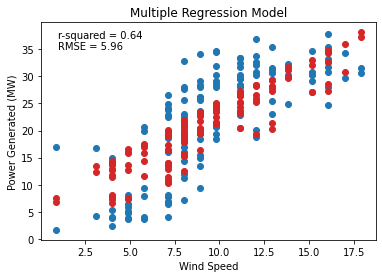

In [63]:
plt.scatter(X_test['Speed'], y_test,color='tab:blue')
plt.scatter(X_test['Speed'], y_pred,color='tab:red')
plt.title('Multiple Regression Model')
plt.xlabel('Wind Speed')
plt.ylabel('Power Generated (MW)')
plt.annotate("r-squared = {:.2f}".format(r2_score(y_test, y_pred)), (1,37))
plt.annotate("RMSE = {:.2f}".format(mse(y_test, y_pred,squared=False)), (1, 35))
plt.savefig('Multiple Linear Regression.png')
plt.show()

In [65]:
# X_train = np.array(X_train).reshape(-1,1)
# y_train = np.array(y_train).reshape(-1,1)
# X_test = np.array(X_test).reshape(-1,1)

In [214]:
# let's look at how the predictions compare to the actual test dataset
df_final = pd.concat([ 
                    X_test.reset_index(drop=True), 
                    y_test.reset_index(drop=True), 
                    pd.DataFrame(y_pred, columns=["predicted_power"])
                ], axis=1)
df_final.head(5)

,Direction,Speed,Hour,Total,predicted_power
0,ESE,5.81152,18.0,9.318094,16.831436
1,W,8.04672,3.0,8.867939,12.750000
2,S,9.83488,6.0,18.395811,22.551474
3,SSE,8.94080,15.0,22.208378,20.687500
4,SSW,4.02336,21.0,7.369278,8.187500


In [215]:
with open('mytable.tex','w') as tf:
    tf.write(df_final.head().to_latex(caption="Concatenated dataframe"))

/var/folders/y4/plwk2b151kx5m3wc40hz9l140000gn/T/ipykernel_50770/2270775240.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(df_final.head().to_latex(caption="Concatenated dataframe"))


In [173]:
X_test = np.array(X_test).reshape(-1,1)

In [213]:
print("Intercept: ", reg_model.named_steps['model'].intercept_)
print("Coefficients:",list(zip(X, reg_model.named_steps['model'].coef_)))

# fit_intercept=False
# Intercept:  0.0
# Coefficients: [('Direction', 36.85281949181896), ('Speed', 513870820001.58246), ('Month', 513870819998.16754)]

# fit_intercept=True
# Intercept:  -107836935808954.48
# Coefficients: [('Direction', 36.86939259624867), ('Speed', 31547026041676.535), ('Month', 31547026041673.0)]

Intercept:  0.0
Coefficients: [('Direction', 36.78235888740439), ('Speed', 386889568253368.8), ('Hour', 386889568253362.3)]


From above we can conclude the following. When we keep the multipler of all independent variables at zero, we generate 0 kW of power. 
Further, a single unit increase in 'Direction', 'Speed' or 'Month' result in a power generation increase of 36 kW, 513870820001 kW and 513870819998 kW respectively. 

# Assignment 

In [ ]:
import os 
host = os.getenv("HOST")
port = os.getenv("PORT")
username = os.getenv("USERNAME")
password = os.getenv("PASSWORD")

In [217]:
client = InfluxDBClient(host=host, port=port, username=username, password=password)
client.switch_database('orkney')

def get_df(results):
    values = results.raw["series"][0]["values"]
    columns = results.raw["series"][0]["columns"]
    df = pd.DataFrame(values, columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index) # Convert to datetime-index
    return df

# Get the last 90 days of power generation data
generation = client.query(
    "SELECT * FROM Generation where time > now()-90d"
    ) # Query written in InfluxQL

# Get the last 90 days of weather forecasts with the shortest lead time
wind  = client.query(
    "SELECT * FROM MetForecasts where time > now()-90d and time <= now() and Lead_hours = '1'"
    ) # Query written in InfluxQL

gen_df = get_df(generation)
wind_df = get_df(wind)

In [176]:
# Column Transformer used to preprocess data before model training
trf = ColumnTransformer(transformers =[
    ('MinMaxScaling', MinMaxScaler(), ['Speed']),
    ("OneHotEncoder", OneHotEncoder(handle_unknown='ignore', sparse=False), ['Direction', 'Hour']),
], remainder ='passthrough')


In [138]:
# function to compare regression models based on rmse and save the best one to directory
def model_comparer(new_mod, old_mod):
    new_pred = new_mod.predict(X_test)
    old_pred = old_mod.predict(X_test)
    new_rmse = mse(y_test,new_pred,squared=False)
    old_rmse = mse(y_test,old_pred,squared=False)
    if new_rmse < old_rmse:
        joblib.dump(new_mod, "best_model.pkl")
    

In [177]:
# function to add a hour column to dataframe
def feature_gen(df):
    df['Hour'] = df.index.hour
    return df

In [248]:
# function to add a hour column to dataframe
def feature_gen(df):
    df['Hour'] = df.index.hour
    return df

# Align the data frames
gen_df = pd.DataFrame(gen_df['Total']).resample('3h').mean()
wind_df = pd.DataFrame(wind_df[['Direction','Speed']])
df = pd.concat([wind_df,gen_df], axis=1)
df = df.dropna()

# Feature generation
df = feature_gen(df)

X = df.drop(columns='Total')
y = df['Total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Make pipeline and compare models
for reg_model in [LinearRegression(),DecisionTreeRegressor(),RandomForestRegressor()]:
    # load stored model
    try:
        best_model_reloaded = joblib.load("best_model.pkl")
        # make pipeline with next regression model
        model = make_pipeline(ct,reg_model)
        # Fit the pipeline
        model = model.fit(X_train,y_train)
        # compare with newly trained and store the best one
        model_comparer(model,best_model_reloaded)
    except FileNotFoundError:  
        model = make_pipeline(ct,LinearRegression())
        model = model.fit(X_train,y_train)
        joblib.dump(model, "best_model.pkl")

####################################################
## Do forecasting with the best one

# Get all future forecasts regardless of lead time
forecasts  = client.query(
    "SELECT * FROM MetForecasts where time > now()"
    ) # Query written in InfluxQL
for_df = get_df(forecasts)

# Limit to only the newest source time 
newest_source_time = for_df["Source_time"].max()
newest_forecasts = for_df.loc[for_df["Source_time"] == newest_source_time].copy()
# Preprocess the forecasts and do predictions in one fell swoop 
# using your best pipeline. Here, adding hour column
newest_forecasts_df = pd.DataFrame(newest_forecasts[['Direction','Speed']])
newest_forecasts_df['Hour'] = newest_forecasts_df.index.hour
# Load best model and predict power generation based on forecasts
best_model_reloaded = joblib.load("best_model.pkl")
preds = best_model_reloaded.predict(newest_forecasts_df)
# evaluate the model with root mean squared error
print(f"Score: {round(best_model_reloaded.score(X_train, y_train),2)}")
y_pred = best_model_reloaded.predict(X_test)
print(f"RMSE: {round(mse(y_test,y_pred,squared=False),2)}")
#print("Our linear model contains", len(best_model_reloaded.steps[1][1].coef_), "coefficients")
#pipeline.predict(newest_forecasts)

Score: 0.89
RMSE: 2.88


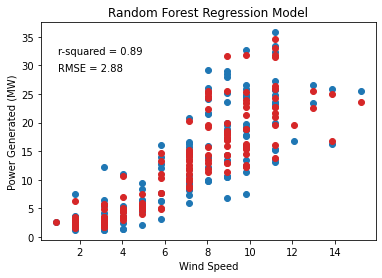

In [249]:
plt.scatter(X_test['Speed'], y_test,color='tab:blue')
plt.scatter(X_test['Speed'], y_pred,color='tab:red')
plt.title('Random Forest Regression Model')
plt.xlabel('Wind Speed')
plt.ylabel('Power Generated (MW)')
plt.annotate("r-squared = {:.2f}".format(r2_score(y_test, y_pred)), (1, 32))
plt.annotate("RMSE = {:.2f}".format(mse(y_test, y_pred,squared=False)), (1, 29))
plt.savefig('RandomForestRegression.png')
plt.show()

In [246]:
# Concatenate the test dataset (what we hope to predict as close as possible) with the predictions made by our model:
pred = pd.concat([ 
                    newest_forecasts_df.reset_index(drop=True), 
                    pd.DataFrame(preds, columns=["predicted_power"])
                ], axis=1)
pred.head()
with open('mytable.tex','w') as tf:
    tf.write(pred.head().to_latex(caption="Weather forecasts and predicted power generation"))

/var/folders/y4/plwk2b151kx5m3wc40hz9l140000gn/T/ipykernel_50770/1639029512.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(pred.head().to_latex(caption="Weather forecasts and predicted power generation"))


In [244]:
# best model
best_model_reloaded = joblib.load("best_model.pkl")
best_model_reloaded
y_pred = best_model_reloaded.predict(X_test)
